<a href="https://colab.research.google.com/github/nihcas2015/SRIP_2025/blob/main/full_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip install xgboost
!pip install tensorflow

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import  f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest


In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
data=pd.read_csv("/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_1.csv")
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_2.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_3.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_4.csv")])

<ipython-input-50-58268d3b2303>:1: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_1.csv")
<ipython-input-50-58268d3b2303>:2: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_2.csv")])
<ipython-input-50-58268d3b2303>:3: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_3.csv")])
<ipython-input-50-58268d3b2303>:4: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_4.csv")])


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3668522 entries, 0 to 668521
Data columns (total 46 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   pkSeqID                           int64  
 1   stime                             float64
 2   flgs                              object 
 3   flgs_number                       int64  
 4   proto                             object 
 5   proto_number                      int64  
 6   saddr                             object 
 7   sport                             object 
 8   daddr                             object 
 9   dport                             object 
 10  pkts                              int64  
 11  bytes                             int64  
 12  state                             object 
 13  state_number                      int64  
 14  ltime                             float64
 15  seq                               int64  
 16  dur                               float64


In [52]:
data.columns

Index(['pkSeqID', 'stime', 'flgs', 'flgs_number', 'proto', 'proto_number',
       'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state',
       'state_number', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min',
       'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate',
       'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto',
       'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP',
       'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport',
       'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP',
       'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory'],
      dtype='object')

In [53]:
data=data.drop(columns=["pkSeqID","stime","flgs","proto","saddr","sport","daddr","dport","state","ltime","seq"])

In [54]:
#dropping correlated columns
#data=data.drop(columns=["bytes","max","spkts","sbytes","dbytes","AR_P_Proto_P_Dport"])

In [55]:
data.isnull().sum()

,0
flgs_number,0
proto_number,0
pkts,0
bytes,0
state_number,0
dur,0
mean,0
stddev,0
sum,0
min,0


In [56]:
data['category'].value_counts()

,count
category,
DDoS,1926624
DoS,1650260
Reconnaissance,91082
Normal,477
Theft,79


In [57]:
data["attack"].value_counts()

,count
attack,
1,3668045
0,477


In [58]:
data["subcategory"].value_counts()

,count
subcategory,
UDP,1981230
TCP,1593180
Service_Scan,73168
OS_Fingerprint,17914
HTTP,2474
Normal,477
Keylogging,73
Data_Exfiltration,6


In [59]:
Y = data[['attack','category','subcategory']]
X= data.drop(['attack','category','subcategory'],axis=1)

In [60]:
X.head()

,flgs_number,proto_number,pkts,bytes,state_number,dur,mean,stddev,sum,min,...,TnP_PerProto,TnP_Per_Dport,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP
0,1,1,8,1980,1,7.056393,0.068909,0.068909,0.137818,0.000000,...,772,772,1.142970,1.12704,96,75,1.133720,1.129970,770,602
1,1,2,2,120,2,0.000131,0.000131,0.000000,0.000131,0.000131,...,8,8,0.003857,15267.20000,1,2,0.005142,0.005142,2,6
2,1,1,8,2126,1,7.047852,0.064494,0.064494,0.128988,0.000000,...,772,772,1.142970,1.12704,96,75,1.135100,1.129970,770,602
3,1,1,8,2024,1,7.047592,0.064189,0.064189,0.128378,0.000000,...,772,772,1.142970,1.12704,96,75,1.135140,1.129970,770,602
4,1,1,8,2319,1,7.046841,0.063887,0.063887,0.127774,0.000000,...,772,772,1.142970,1.12704,96,75,1.135260,1.129970,770,602


In [61]:
le = LabelEncoder()
Y['category'] = le.fit_transform(Y['category'])
Y['subcategory'] = le.fit_transform(Y['subcategory'])
Y.head()

<ipython-input-61-437eb0fff2ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['category'] = le.fit_transform(Y['category'])
<ipython-input-61-437eb0fff2ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['subcategory'] = le.fit_transform(Y['subcategory'])


,attack,category,subcategory
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


In [62]:
"""
mi_attack = mutual_info_classif(X, Y["attack"])
mi_subcat = mutual_info_classif(X, Y["subcategory"])
mi_cat    = mutual_info_classif(X, Y["category"])
mi_avg = (mi_attack + mi_subcat + mi_cat) / 3

df_mi = pd.DataFrame({
    'feature': X.columns.tolist(),
    'MI_attack': mi_attack,
    'MI_subcategory': mi_subcat,
    'MI_category': mi_cat,
    'MI_average': mi_avg
})

df_mi_sorted = df_mi.sort_values(by='MI_average', ascending=False)
top_features = df_mi_sorted.head(20)['feature'].tolist()
X = X[top_features]
"""

'\nmi_attack = mutual_info_classif(X, Y["attack"])\nmi_subcat = mutual_info_classif(X, Y["subcategory"])\nmi_cat    = mutual_info_classif(X, Y["category"])\nmi_avg = (mi_attack + mi_subcat + mi_cat) / 3\n\ndf_mi = pd.DataFrame({\n    \'feature\': X.columns.tolist(),\n    \'MI_attack\': mi_attack,\n    \'MI_subcategory\': mi_subcat,\n    \'MI_category\': mi_cat,\n    \'MI_average\': mi_avg\n})\n\ndf_mi_sorted = df_mi.sort_values(by=\'MI_average\', ascending=False)\ntop_features = df_mi_sorted.head(20)[\'feature\'].tolist()\nX = X[top_features]\n'

In [63]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


In [65]:
"""base_model = LogisticRegression(max_iter=50, random_state=42)

rfe_selector = RFE(estimator=base_model, n_features_to_select=15, step=1)
rfe_selector = rfe_selector.fit(X_train, y_train['attack'])

rfe_selector1 = RFE(estimator=base_model, n_features_to_select=15, step=1)
rfe_selector1 = rfe_selector1.fit(X_train, y_train['subcategory'])

rfe_selector2 = RFE(estimator=base_model, n_features_to_select=15, step=1)
rfe_selector2 = rfe_selector2.fit(X_train, y_train['category'])

combined_mask = rfe_selector.support_ | rfe_selector1.support_ | rfe_selector2.support_

X_train = pd.DataFrame(X_train, columns=top_features)
X_train = X_train.loc[:, X_train.columns[combined_mask]]


X_test = pd.DataFrame(X_test, columns=top_features)
X_test = X_test.loc[:, X_test.columns[combined_mask]]
"""

"base_model = LogisticRegression(max_iter=50, random_state=42)\n\nrfe_selector = RFE(estimator=base_model, n_features_to_select=15, step=1)\nrfe_selector = rfe_selector.fit(X_train, y_train['attack'])\n\nrfe_selector1 = RFE(estimator=base_model, n_features_to_select=15, step=1)\nrfe_selector1 = rfe_selector1.fit(X_train, y_train['subcategory'])\n\nrfe_selector2 = RFE(estimator=base_model, n_features_to_select=15, step=1)\nrfe_selector2 = rfe_selector2.fit(X_train, y_train['category'])\n\ncombined_mask = rfe_selector.support_ | rfe_selector1.support_ | rfe_selector2.support_\n\nX_train = pd.DataFrame(X_train, columns=top_features)\nX_train = X_train.loc[:, X_train.columns[combined_mask]]\n\n\nX_test = pd.DataFrame(X_test, columns=top_features)\nX_test = X_test.loc[:, X_test.columns[combined_mask]]\n"

In [66]:
X_train

array([[ 0.58919129, -1.0968893 , -0.03223497, ..., -0.0342788 ,
        -0.63812509, -0.64164073],
       [-0.56655166,  1.9058624 , -0.0581893 , ..., -0.03430447,
        -1.39472632, -1.25097203],
       [ 0.58919129, -1.0968893 , -0.02358352, ..., -0.03427783,
        -0.39107163, -0.27927325],
       ...,
       [ 0.58919129, -1.0968893 , -0.03223497, ..., -0.03428042,
        -0.51901003, -0.49392405],
       [-0.56655166, -1.0968893 , -0.04953786, ..., -0.00391258,
        -1.01532279, -0.93245794],
       [-0.56655166,  0.90494517,  0.08023382, ..., -0.03426426,
         2.33313396,  2.57119703]])

In [67]:
"""class RandomForest:
    def __init__(self,max_depth):
        self.rfc_attack = RandomForestClassifier(max_depth=max_depth)
        self.rfc_category = RandomForestClassifier(max_depth=max_depth)
        self.rfc_subcategory = RandomForestClassifier(max_depth=max_depth)

    def fit(self,X_train,y_train):
        self.rfc_attack.fit(X_train,y_train['attack'])

        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)
        self.rfc_category.fit(features_category,y_train['category'])

        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)
        self.rfc_subcategory.fit(features_subcategory,y_train['subcategory'])

    def predict(self,X_test):
        predict_attack = self.rfc_attack.predict(X_test)

        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)
        predict_category = self.rfc_category.predict(test_category)

        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)
        predict_subcategory = self.rfc_subcategory.predict(test_subcategory)



        return pd.DataFrame({'attack':predict_attack,'category':predict_category,'subcategory':predict_subcategory})"""

"class RandomForest:\n    def __init__(self,max_depth):\n        self.rfc_attack = RandomForestClassifier(max_depth=max_depth)\n        self.rfc_category = RandomForestClassifier(max_depth=max_depth)\n        self.rfc_subcategory = RandomForestClassifier(max_depth=max_depth)\n\n    def fit(self,X_train,y_train):\n        self.rfc_attack.fit(X_train,y_train['attack'])\n\n        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)\n        self.rfc_category.fit(features_category,y_train['category'])\n\n        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)\n        self.rfc_subcategory.fit(features_subcategory,y_train['subcategory'])\n\n    def predict(self,X_test):\n        predict_attack = self.rfc_attack.predict(X_test)\n\n        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)\n        predict_category = self.rfc_category.predict(test_category)\n\n   

In [68]:
"""class NaiveBayes:
   def __init__(self):
              self.nb_attack = GaussianNB()
        self.nb_category = GaussianNB()
        self.nb_subcategory = GaussianNB()

    def fit(self,X_train,y_train):
        self.nb_attack.fit(X_train,y_train['attack'])

        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)
        self.nb_category.fit(features_category,y_train['category'])


        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)
        self.nb_subcategory.fit(features_subcategory,y_train['subcategory'])

    def predict(self,X_test):
        predict_attack = self.nb_attack.predict(X_test)

        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)
        predict_category = self.nb_category.predict(test_category)

        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)
        predict_subcategory = self.nb_subcategory.predict(test_subcategory)

        return pd.DataFrame({'attack':predict_attack,'category':predict_category,'subcategory':predict_subcategory})"""

"class NaiveBayes:\n   def __init__(self):\n              self.nb_attack = GaussianNB()\n        self.nb_category = GaussianNB()\n        self.nb_subcategory = GaussianNB()\n\n    def fit(self,X_train,y_train):\n        self.nb_attack.fit(X_train,y_train['attack'])\n\n        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)\n        self.nb_category.fit(features_category,y_train['category'])\n\n\n        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)\n        self.nb_subcategory.fit(features_subcategory,y_train['subcategory'])\n\n    def predict(self,X_test):\n        predict_attack = self.nb_attack.predict(X_test)\n\n        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)\n        predict_category = self.nb_category.predict(test_category)\n\n        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)\n        pre

In [69]:
"""class DecisionTree:
    def __init__(self,criterion,max_depth=5):
        self.dtree_attack = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth)
        self.dtree_category = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth)
        self.dtree_subcategory = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth)

    def fit(self,X_train,y_train):
        self.dtree_attack.fit(X_train,y_train['attack'])

        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)
        self.dtree_category.fit(features_category,y_train['category'])

        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)
        self.dtree_subcategory.fit(features_subcategory,y_train['subcategory'])

    def predict(self,X_test):
        predict_attack = self.dtree_attack.predict(X_test)

        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)
        predict_category = self.dtree_category.predict(test_category)

        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)
        predict_subcategory = self.dtree_subcategory.predict(test_subcategory)

        return pd.DataFrame({'attack':predict_attack,'category':predict_category,'subcategory':predict_subcategory})"""

"class DecisionTree:\n    def __init__(self,criterion,max_depth=5):\n        self.dtree_attack = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth)\n        self.dtree_category = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth)\n        self.dtree_subcategory = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth)\n\n    def fit(self,X_train,y_train):\n        self.dtree_attack.fit(X_train,y_train['attack'])\n\n        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)\n        self.dtree_category.fit(features_category,y_train['category'])\n\n        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)\n        self.dtree_subcategory.fit(features_subcategory,y_train['subcategory'])\n\n    def predict(self,X_test):\n        predict_attack = self.dtree_attack.predict(X_test)\n\n        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1

In [70]:
"""class GradientBoost:
    def __init__(self):
        self.xgb_attack = XGBClassifier()
        self.xgb_category = XGBClassifier()
        self.xgb_subcategory = XGBClassifier()

    def fit(self,X_train,y_train):
        self.xgb_attack.fit(X_train,y_train['attack'])

        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)
        self.xgb_category.fit(features_category,y_train['category'])

        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)
        self.xgb_subcategory.fit(features_subcategory,y_train['subcategory'])

    def predict(self,X_test):
        predict_attack = self.xgb_attack.predict(X_test)

        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)
        predict_category = self.xgb_category.predict(test_category)

        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)
        predict_subcategory = self.xgb_subcategory.predict(test_subcategory)

        return pd.DataFrame({'attack':predict_attack,'category':predict_category,'subcategory':predict_subcategory})"""

"class GradientBoost:\n    def __init__(self):\n        self.xgb_attack = XGBClassifier()\n        self.xgb_category = XGBClassifier()\n        self.xgb_subcategory = XGBClassifier()\n\n    def fit(self,X_train,y_train):\n        self.xgb_attack.fit(X_train,y_train['attack'])\n\n        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)\n        self.xgb_category.fit(features_category,y_train['category'])\n\n        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)\n        self.xgb_subcategory.fit(features_subcategory,y_train['subcategory'])\n\n    def predict(self,X_test):\n        predict_attack = self.xgb_attack.predict(X_test)\n\n        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)\n        predict_category = self.xgb_category.predict(test_category)\n\n        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)

In [71]:
def display_metrics(y_true, y_pred, title):
  print(f"--- {title} ---")
  print("\nClassification Report:")
  report = classification_report(y_true, y_pred, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print(df[:-3])

  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title(f"Confusion Matrix for {title}")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

  print("Accuracy:",df["precision"][-3])

**Random Forest**

In [72]:
"""rf = RandomForest(max_depth=3)
rf.fit(X_train,y_train)

predictions_rfc = rf.predict(X_test)"""

'rf = RandomForest(max_depth=3)\nrf.fit(X_train,y_train)\n\npredictions_rfc = rf.predict(X_test)'

In [73]:
"""
display_metrics(y_test['attack'], predictions_rfc['attack'], "Attack Prediction")"""



'\ndisplay_metrics(y_test[\'attack\'], predictions_rfc[\'attack\'], "Attack Prediction")'

In [74]:
#display_metrics(y_test['category'], predictions_rfc['category'], "Category Prediction")


In [75]:
#display_metrics(y_test['subcategory'], predictions_rfc['subcategory'], "Subcategory Prediction")

Naive Bayes

In [76]:
#nb = NaiveBayes()
#nb.fit(X_train,y_train)

#predictions_nb = nb.predict(X_test)

In [77]:
#display_metrics(y_test['attack'], predictions_nb['attack'], title="Attack")

In [78]:
#display_metrics(y_test['category'], predictions_nb['category'], title="Category")

In [79]:
#display_metrics(y_test['subcategory'], predictions_nb['subcategory'], title="Subcategory")

**Decision Tree **

In [80]:
#dtree = DecisionTree("gini")
##dtree.fit(X_train,y_train)
#predictions_dtree = dtree.predict(X_test)

In [81]:
#display_metrics(y_test['attack'], predictions_dtree['attack'], title="Attack")

In [82]:
#display_metrics(y_test['category'], predictions_dtree['category'], title=" Category")

In [83]:
#display_metrics(y_test['subcategory'], predictions_dtree['subcategory'], title=" Subcategory")

**Gradient Boost**

In [84]:
#xgb = GradientBoost()
#xgb.fit(X_train,y_train)
#predictions_xgb = xgb.predict(X_test)

In [85]:
#display_metrics(y_test['attack'], predictions_xgb['attack'], title="Attack")

In [86]:
#display_metrics(y_test['category'], predictions_xgb['category'], title="Category")

In [87]:
#display_metrics(y_test['subcategory'], predictions_xgb['subcategory'], title="Subcategory")

In [88]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
rf = RandomForestClassifier()


meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=50)


stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=5
)


stacked.fit(X_train, y_train["subcategory"])



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:20:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:38:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:41:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:44:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:47:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=Non...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('rf', RandomForestClassifier())],
                   final_estimator=LogisticRegression(max_iter=50,
                                                      multi_class='multinomial'))

--- Subcategory ---

Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


   precision    recall  f1-score   support
0   0.000000  0.000000  0.000000       1.0
1   1.000000  0.995960  0.997976     495.0
2   0.000000  0.000000  0.000000      15.0
3   1.000000  0.968421  0.983957      95.0
4   0.988780  0.983812  0.986290    3583.0
5   0.995906  0.997335  0.996620   14634.0
6   0.999934  0.999991  0.999962  318636.0
7   0.999992  0.999992  0.999992  396246.0


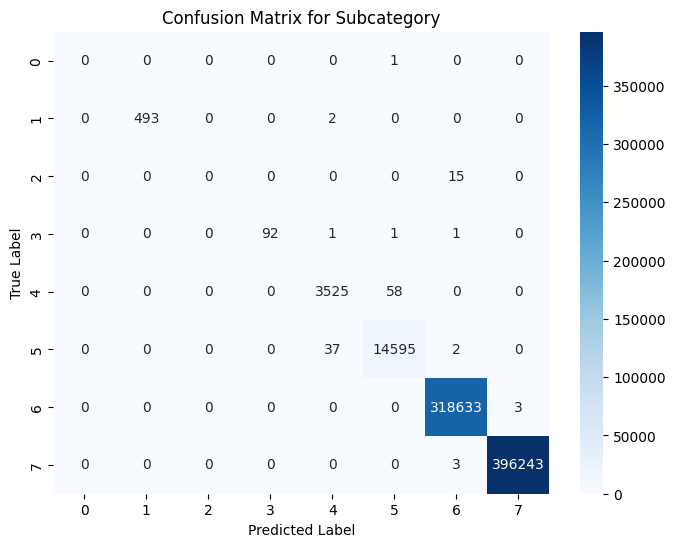

Accuracy: 0.9998309947458447


<ipython-input-71-8576f023c03b>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Accuracy:",df["precision"][-3])


In [89]:
y_pred = stacked.predict(X_test)
display_metrics(y_test["subcategory"], y_pred, title="Subcategory")



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:58:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:17:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:18:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:18:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:19:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

--- Attack ---

Classification Report:
   precision  recall  f1-score   support
0   0.000000     0.0  0.000000      95.0
1   0.999871     1.0  0.999935  733610.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


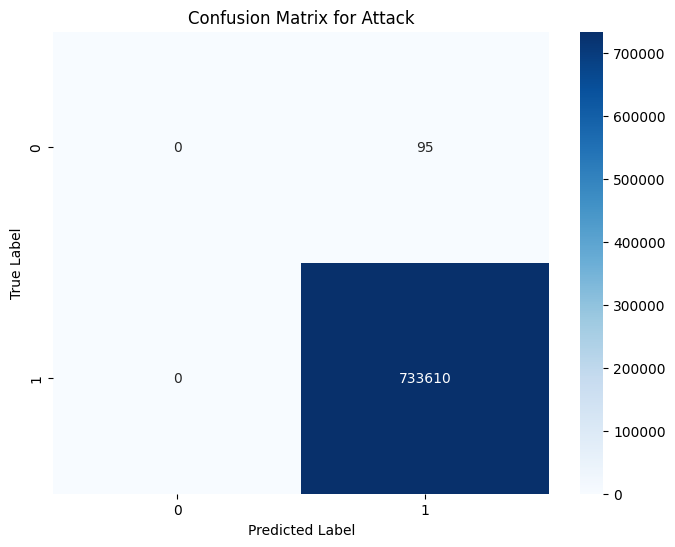

Accuracy: 0.9998705201681874


<ipython-input-71-8576f023c03b>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Accuracy:",df["precision"][-3])


In [90]:
stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=5
)


stacked.fit(X_train, y_train["attack"])
y_pred = stacked.predict(X_test)
display_metrics(y_test["attack"], y_pred,title="Attack")



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:29:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:55:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:57:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:00:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:02:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

--- category ---

Classification Report:
   precision    recall  f1-score   support
0   0.999958  0.999995  0.999977  385325.0
1   0.999961  0.999997  0.999979  330052.0
2   1.000000  0.842105  0.914286      95.0
3   0.999671  0.999945  0.999808   18217.0
4   0.000000  0.000000  0.000000      16.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


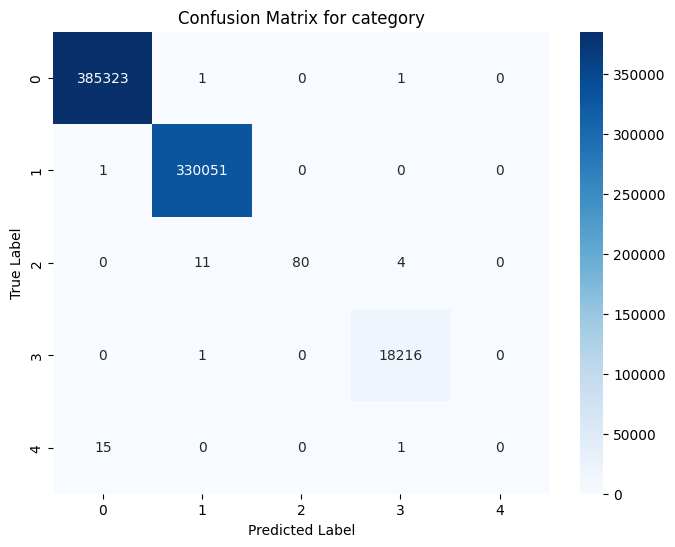

Accuracy: 0.9999522969040691


<ipython-input-71-8576f023c03b>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Accuracy:",df["precision"][-3])


In [91]:
stacked = StackingClassifier(
    estimators=[('xgb', xgb), ('rf', rf)],
    final_estimator=meta_model,
    cv=5
)


stacked.fit(X_train, y_train["category"])
y_pred = stacked.predict(X_test)
display_metrics(y_test["category"], y_pred,title="category")

